# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273
┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1273
┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1273


## Settings

In [2]:
# data loading
sound_file = "../data/airco.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 1                      # specify step size of buffer
buffer_size = 30                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-4               # specify observation noise var
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 1
iterations = 5
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time_clean = x_time
x_time = x_time_clean #+ rand(Distributions.Normal(0, sqrt(var_observation)), length(x_time_clean))

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCOCo4+uVQbP5NkKT/vczw/1Uc9Pw7RWD+YxnY/PseJP+gikj+4foM/DQRiPyyDTz+KR0Q/zPhZP0NkVT/x+Ec/l+0WP4z3FT8+qRg/C6A3P072Ej8LJgY//SP5PiBWgz4UaME+kZGQPpcHvr1r5t6+dBoAvxlDlr5dhX89y+lDPvakZ703LnW+vPvGvkizYr7v2Nq98/aivs08sb7jUxW/mnpYv7NOdL/EdGK/CxATv4CKHb+1X/y+qwMqvzEqPb87lkm/fx9/vyVyib9J3IS/YxeOv57edb9EwD6/o/fpvggA+b4hAyC/fnYNvzN4+L5DYc++U7kmvitRxr0oa/O89taHvtmqHL/1eyS/WNfJvibLfb1ypwM+5kcIPNWwL76kLwm+9Z1VPiaeAD8/yOE+VEG8PrgSxT3Zd+09g8cZPy1Dfj/fFIo/jtpXP/eRHD/lMkM/CoWIP1GTrT+HmKk/faaOP03snj/Is6k/bPC8Pyi4qj9OtYg/JwB9P7yQbj9AdnM/UgtsP7BCPD8t6Qc/1ZQYP5hrRT9aQSc/qnaFPqwOhb0+k5i9wgSuPceJcj4wWkI80oGrvviaP79891y/Neosv4TIyb4SlPe+uowxvzpxVL/vT2u/9XRzvw46Yr+X8GW/aQRXvzQeQ7/x1Tm/FNAyv8VON7+pe/2+v38Ev3KTBL/jNeO+cb7/vqIbA79A0Ni+re8Ov+FnBr/pxgK/MkP+vvhfub4Zbpm+QyAhv7jOir+9L5y/8e2Kv6+UT78+EwS/4JrVvlPg/L48rEe/3HhCvz3FPr8U5Cm/j8LZvsV1jr6DIqe+q5E8vjXCEL7WOQS+H847PXL91D6KWi8/APFMPzEiRz+9kRo/bDslP0dvVT82lI4/DaCtP1qBrD/k6pA/8iiDP9vthj84hK8/0DnIP5isqj88OIU/GH43P0nfKT/RXjk/TgqLPz1Yvj/H9sQ/EXCwP7Ariz/Ty4I/YgVjPyV2dz8QFFI/VdYZPxhK6j7facU+Fwe5PitzcD7uF9Y8wY5EvreS8r516/K+SlX8vgxBD7/X10S/HUiNv0Z0qb9XnKC/ZYiKv1Xke7/Da4+/JmSov5GVwb/bkrO/xuCcv42gpL/c9qq/yGuUv2RSib/rpGS/oG9ovyzpX7/Valy/m0U2v9Z9FL+EeBm/QVMJv/r43b5NesK+oGu3vpTGrr42wau+NzBFvn+B2b5APgC+fTUkPikvLz6yXKw747p8vjzKlb0RjQO+SJGIPUEV6j4cfd4+kK6sPfVRwrxL/Qg+orQGP2vdTD/hhHg/UKlfP2UyMD/zSEM/5QtVP+7NYj/P5Vs/mtlQPw7GOD8qvhM/COcIP9aMOD/B/kE/78BgP/h8VD/d3zo/NbENP8W8tD66YDQ+ubjYPh08CD9QmT8/icEfP4X9wz7gZlc+RNxCPuv0CD81uDY/7hVFP97wHD+BV6094vKoPXKaLD7d2kc++uTIPTyNcr27qsu9aS/0veVhDjzqkhw9cvLavQ0yp77cwNy+qfXivpMqor5vsfu+uGF8v+yBiL8/Cp2/xkKMv4ivfb8AT5O/nfq5v5bc0r/r9L6/Yuywv/WhlL9ZLYK/l2qZvzXJkb9VkXy/PJgGvyCjzb5oTc2+1GGqvsxOYb47tsQ805w0Pi7ETz4BeWs+00G+PoDRHT9ogyI/MIH0PrX0nD6ztAY+Rq4+PrDGLz+zBEI/Cd1BP3ZIBz9nWQw+SS/ZPaajPj4wph4/ZSUhP4u4AT/0DeM++zEYPzEWIT84fE4/tIpXPw7/VT/cIBw/GJq1PoKtIj+PgEg/lQtkP5fcUD8tDSk/W8b/Pj6SAz+Mbhc/VsUFP38r8D6u55U+R8KHPjLzoT7uLoE+uwyTPs3xkT7su0k+YrQzPlGguT0DWwU+YAN4PI+FTr7J2Y2+W688vi9zF76Ds4C9t0nyvA8rlr77Ztq+kf4Av91CzL7y4ly+Ap7evuM8PL+mxma/l8Nyv2YYjr+vloS/c9yHvwwhhr9Zmoq/LV6cvxONtL8XbuK/qX30v4FW4L/cvtC/zPuvvw3/or8CrJq/69+Xv+x1f78UvFG/7dgZvxmzqr4tjXq+bH4kvkoWij4mewQ/rnhaP2CahD+ytl4/LWw1Pwf+Pz+G2lU/+AqEP+icqD+p96Y/cc+TP9Vncj9HJnQ/kD2dPy3coj9GlpQ/bkN/P1uLYj++1IM/D4KTP1zuij+YQXg/980+PzpcPj/R3jI/7DJMP3xnQz/zXic/4B0SPwbBLT+ptzc/x0ItPy0b2z4wQdM+TjztPtLMEj81fCs/fqIEPzsRlz5963a92MlKvshhGb47NLy+Pu7uvnDFFr+R9Se/kNTivkTo5b7cDBy/KDF3v3xAmr87sY2/RLGDv9Bdjr92hKO/md+0v0lCn7+LSX6/04Qfv88NFb+LzVy/HbqYvwKLnr/+j4K/MwY8v7aULL8+VRW/aTopvxP/Hr8UYMO+l/HAvvWWx75rI5W+QPRYvvOFA74vG+C9tLBMvjQj576HPby+57lFvbe3nj5dos0+UsV3PkyQSD4BW2c9TfKjPp1/kD5hBvM9EGDIPe7cGT79BNE+tBcZP8IkJj/0gBs/jm4xP1pnUz/3coY/JmqiPwXCpT+3poE/YKVyP2Jlbj+Vklw/Qi+SP5Shbz81628/Hf6KPxFJlT9TRIk//yCSP1R9nz/JYog/tfF0P/b1Sz+6zhk/P1cfP6YdPT+TvCw/ZEG/PhvNNT5sAq29ZEGIvu8Xm740eAu/ek76vsyWHr8NWym/Xfpiv9cTn78SC6y/iVWVvyOWhb99o4+/t92xv+3m47/HHvK/U4fov5SawL/EHpC/A/6Jv3gfgb+/Pne/paZ8v2nNX78l6FG/WFhrv4V5ML86Kga/asxrvtnmCr6m3Xu+Rerfvi308r4dn3W+MYAzPi67nj3KtNm9Y2pTvgFGs73LByc+mfHpPt5c7j5Vyr0+39uvPjqu/D5b5RQ/t9ZjP3y9ej9aZlg/Lx1MP6V2WD9Gk1Y/JO8YP7jRyz4NdVM+Chr+PrgeTj/cgIU/K4dcP9W7ED+FrJg+sJfjPmUyTD+7vHA/jfV0PzzKez8DHnI/hHqdP0Q9mj+Lnpw/H2V1P1G8Oj/shR8/sCdJPwCsgj/CUZM/1IV0P4JYID/7u7A+Z+6PPtIArD4VEbE+6E88PgDdtb1inT6+NyiQvtZ1AbzdDHI9qHAyPHVBnL4kcwi/XTFSv4fsjr86JqC/CAWivy2dnr9EMae/1mGWv9Brkb/9t52/J1KUv+9sk787IKW/iJqtv/t4rb/pwri/Xw7Zv+P7zr+k4LW/T7Wyv0cqmL+kjoC/N69xv6aYSL9xVVi/Yrllv7zxKb837yW/SU0Kv5za3r44Qs2+F9knvsCqqD3d0I0+kDgCP51JBD/6Fh8/rdMTP3drDT+GITE/tpBGP/2qLj87ykY/ZsUrP03eJz93wlc/7/NPP8VSVj9aDj4/jRQUP4R2sj7J5oI+POffPSPu4z6zwB0/13tRPwsuIT+xDfU+C1MZP6ZfSD8W7z4/FNgKP+aabT4D13o99HUNP/QneD+UNJw/BcOHPz3SHz9ub2s+sCoHPqW9nz4Kyyk/YeIhPzgZtz7viCi+D7q7vl33QL7oiys+bxMgPpO7A754+qO++5/7vmKmJ7+AFTa/w0FOv7orgr97oY+/Y/Z5v++Hdb/97E+/oMJWvwbvbb+j3Gq/gk2Cv780hL9/xHm/BYd5v9kSQr+gBgi/3HnXvijAq76D8Nq+pB2yvp2f0j3lWRo/dA9bP2OmGT/oYIU+b7YePZ13mD2LMMw+7posP72EOT+zTyo/IVepPiWqiz7ngRE/JYBMP8uLYD8Nq

## Visualize data

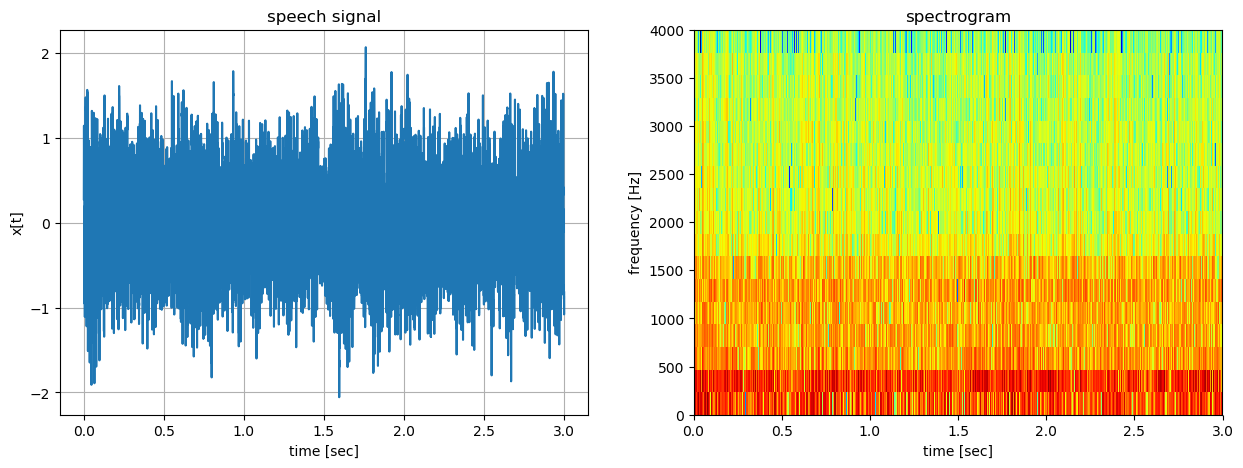

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
γ = Array{Variable,1}(undef, 2*length(freq))
θ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ,k)] γ[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ,k)), placeholder(pad(:b_γ,k)))
    @RV [id=pad(:θ,k)] θ[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ,k), dims=(AR_order,)), placeholder(pad(:Σ_θ,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.Autoregressive(θ[k], z_min[k], γ[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 13618978744164594273 -->
 13618978744164594273 
 
 Gam 
 gamma_17 
 
<!-- 10544199987106920336 -->
 10544199987106920336 
 
 placeholder_b_γ_17 
 
<!-- 13618978744164594273--10544199987106920336 -->
 13618978744164594273--10544199987106920336 
 
 b_γ_17 
 1 out 
 3 b 
 
<!-- 1735956640050796182 -->
 1735956640050796182 
 
 placeholder_a_γ_17 
 
<!-- 13618978744164594273--1735956640050796182 -->
 13618978744164594273--1735956640050796182 
 
 a_γ_17 
 1 out 
 2 a 
 
<!-- 10096451676801977385 -->
 10096451676801977385 
 
 𝒩 
 gaussianmeanvariance_61 
 
<!-- 4855477322293008914 -->
 4855477322293008914 
 
 placeholder_μ_θ_30 
 
<!-- 10096451676801977385--4855477322293008914 -->
 10096451676801977385--4855477322293008914 
 
 μ_θ_30 
 1 out 
 2 m 
 
<!-- 1601189611439801542 -->
 1601189611439801542 
 
 placeholder_Σ_θ_30 
 
<!-- 10096451676801977385--1601189611439801542 -->
 10096451676801977385--1601189611439801542 
 
 Σ_θ_30 
 1 out 
 3 v 
 
<!-- 14733294633622567323 -->
 14733294633622567323 
 
 × 
 multiplication_15 
 
<!-- 14437115690441200455 -->
 14437115690441200455 
 
 placeholder_Ceme1_15 
 
<!-- 14733294633622567323--14437115690441200455 -->
 14733294633622567323--14437115690441200455 
 
 Ceme1_15 
 1 out 
 3 a 
 
<!-- 12916011724842507966 -->
 12916011724842507966 
 
 AR 
 autoregressive_15 
 
<!-- 14733294633622567323--12916011724842507966 -->
 14733294633622567323--12916011724842507966 
 
 z_15 
 1 y 
 2 in1 
 
<!-- 6710097778397861474 -->
 6710097778397861474 
 
 + 
 addition_3 
 
<!-- 14419631938791176790 -->
 14419631938791176790 
 
 + 
 addition_2 
 
<!-- 6710097778397861474--14419631938791176790 -->
 6710097778397861474--14419631938791176790 
 
 variable_32 
 1 out 
 2 in1 
 
<!-- 7945343739643865477 -->
 7945343739643865477 
 
 × 
 multiplication_4 
 
<!-- 6710097778397861474--7945343739643865477 -->
 6710097778397861474--7945343739643865477 
 
 variable_4 
 1 out 
 3 in2 
 
<!-- 17099452885774469174 -->
 17099452885774469174 
 
 placeholder_b_γ_21 
 
<!-- 11217205909411393124 -->
 11217205909411393124 
 
 placeholder_a_γ_07 
 
<!-- 14709727265781766382 -->
 14709727265781766382 
 
 placeholder_Σ_z_min_19 
 
<!-- 1247077043847811580 -->
 1247077043847811580 
 
 placeholder_Σ_z_min_29 
 
<!-- 4208482239490606027 -->
 4208482239490606027 
 
 placeholder_b_γ_07 
 
<!-- 1851253179487036951 -->
 1851253179487036951 
 
 placeholder_Ceme1_21 
 
<!-- 15589874821964729484 -->
 15589874821964729484 
 
 × 
 multiplication_17 
 
<!-- 9342100979594371147 -->
 9342100979594371147 
 
 placeholder_Ceme1_17 
 
<!-- 15589874821964729484--9342100979594371147 -->
 15589874821964729484--9342100979594371147 
 
 Ceme1_17 
 1 out 
 3 a 
 
<!-- 9835193297864033700 -->
 9835193297864033700 
 
 AR 
 autoregressive_17 
 
<!-- 15589874821964729484--9835193297864033700 -->
 15589874821964729484--9835193297864033700 
 
 z_17 
 1 y 
 2 in1 
 
<!-- 9973576899392715574 -->
 9973576899392715574 
 
 𝒩 
 gaussianmeanvariance_20 
 
<!-- 3786918292815121149 -->
 3786918292815121149 
 
 placeholder_Σ_z_min_10 
 
<!-- 9973576899392715574--3786918292815121149 -->
 9973576899392715574--3786918292815121149 
 
 Σ_z_min_10 
 1 out 
 3 v 
 
<!-- 1088221946698877395 -->
 1088221946698877395 
 
 placeholder_μ_z_min_10 
 
<!-- 9973576899392715574--1088221946698877395 -->
 9973576899392715574--1088221946698877395 
 
 μ_z_min_10 
 1 out 
 2 m 
 
<!-- 12192576977591589643 -->
 12192576977591589643 
 
 placeholder_μ_θ_05 
 
<!-- 10142996302843526372 -->
 10142996302843526372 
 
 plac

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, z, z_min, γ, ids=[:θ :z :z_min :γ])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [7]:
println(algo)

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 60))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_30]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_30]))
messages[2] = ruleVariationalARIn3PPPN(marginals[:z_30], marginals[:z_min_30], marginals[:θ_30], nothing)
messages[3] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_29]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_29]))
messages[4] = ruleVariationalARIn3PPPN(marginals[:z_29], marginals[:z_min_29], marginals[:θ_29], nothing)
messages[5] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_28]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_28]))
messages[6] = ruleVariationalARIn3PPPN(marginals[:z_28], marginals[:z_min_28], marginals[:θ_28], nothing)
messa

## Perform inference

In [8]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_γ_min = Array{Float64,1}(undef, 2*length(freq))
b_γ_min = Array{Float64,1}(undef, 2*length(freq))
μ_θ_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_θ_min = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min[k] = randn(AR_order)
    Σ_z_min[k] = 1e10*Ic(AR_order)
    a_γ_min[k] = 0.001
    b_γ_min[k] = 0.001
    μ_θ_min[k] = randn(AR_order)
    Σ_θ_min[k] = 1e0*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ_min[k], b=b_γ_min[k])
    marginals[pad(:θ, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ_min[k], v=Σ_θ_min[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min[k], v=Σ_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]
μ_s = Array{Float64,1}[]
Σ_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme1,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:a_γ, f)] = a_γ_min[f]
        data[pad(:b_γ, f)] = b_γ_min[f]
        data[pad(:μ_θ, f)] = μ_θ_min[f]
        data[pad(:Σ_θ, f)] = Σ_θ_min[f]
        data[pad(:μ_z_min, f)] = μ_z_min[f]
        data[pad(:Σ_z_min, f)] = Σ_z_min[f]
    end
    
    # run stepz! for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # get prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[179].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[179].dist))
    
    # infer parameters
    for it = 1:iterations
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ!, data, marginals, messages)
        
    end
    
    # get spectral component values
    push!(μ_s, [ForneyLab.unsafeMean(marginals[pad(:z, k)])[1] for k=1:2*length(freq)])
    push!(Σ_s, diagm([ForneyLab.unsafeCov(marginals[pad(:z, k)])[1,1] for k=1:2*length(freq)]))
    
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_γ_min[f] = marginals[pad(:γ,f)].params[:a]
        b_γ_min[f] = marginals[pad(:γ,f)].params[:b]
        μ_θ_min[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
        Σ_θ_min[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:19:524:39


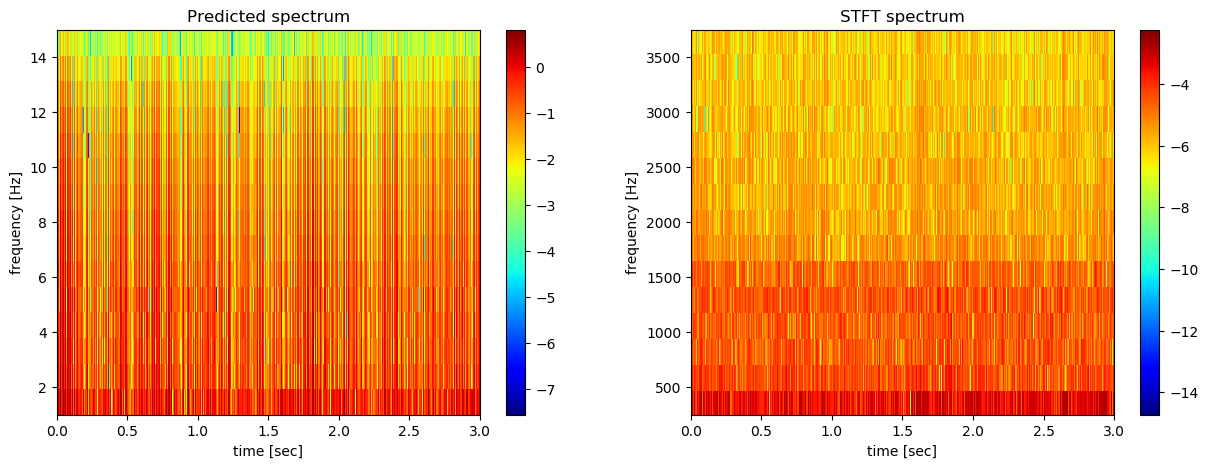

In [9]:
# convert μ_x to a 1d array
#μ_x_pred = expand((hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCOCo4+uVQbP5NkKT/vczw/1Uc9Pw7RWD+YxnY/PseJP+gikj+4foM/DQRiPyyDTz+KR0Q/zPhZP0NkVT/x+Ec/l+0WP4z3FT8+qRg/C6A3P072Ej8LJgY//SP5PiBWgz4UaME+kZGQPpcHvr1r5t6+dBoAvxlDlr5dhX89y+lDPvakZ703LnW+vPvGvkizYr7v2Nq98/aivs08sb7jUxW/mnpYv7NOdL/EdGK/CxATv4CKHb+1X/y+qwMqvzEqPb87lkm/fx9/vyVyib9J3IS/YxeOv57edb9EwD6/o/fpvggA+b4hAyC/fnYNvzN4+L5DYc++U7kmvitRxr0oa/O89taHvtmqHL/1eyS/WNfJvibLfb1ypwM+5kcIPNWwL76kLwm+9Z1VPiaeAD8/yOE+VEG8PrgSxT3Zd+09g8cZPy1Dfj/fFIo/jtpXP/eRHD/lMkM/CoWIP1GTrT+HmKk/faaOP03snj/Is6k/bPC8Pyi4qj9OtYg/JwB9P7yQbj9AdnM/UgtsP7BCPD8t6Qc/1ZQYP5hrRT9aQSc/qnaFPqwOhb0+k5i9wgSuPceJcj4wWkI80oGrvviaP79891y/Neosv4TIyb4SlPe+uowxvzpxVL/vT2u/9XRzvw46Yr+X8GW/aQRXvzQeQ7/x1Tm/FNAyv8VON7+pe/2+v38Ev3KTBL/jNeO+cb7/vqIbA79A0Ni+re8Ov+FnBr/pxgK/MkP+vvhfub4Zbpm+QyAhv7jOir+9L5y/8e2Kv6+UT78+EwS/4JrVvlPg/L48rEe/3HhCvz3FPr8U5Cm/j8LZvsV1jr6DIqe+q5E8vjXCEL7WOQS+H847PXL91D6KWi8/APFMPzEiRz+9kRo/bDslP0dvVT82lI4/DaCtP1qBrD/k6pA/8iiDP9vthj84hK8/0DnIP5isqj88OIU/GH43P0nfKT/RXjk/TgqLPz1Yvj/H9sQ/EXCwP7Ariz/Ty4I/YgVjPyV2dz8QFFI/VdYZPxhK6j7facU+Fwe5PitzcD7uF9Y8wY5EvreS8r516/K+SlX8vgxBD7/X10S/HUiNv0Z0qb9XnKC/ZYiKv1Xke7/Da4+/JmSov5GVwb/bkrO/xuCcv42gpL/c9qq/yGuUv2RSib/rpGS/oG9ovyzpX7/Valy/m0U2v9Z9FL+EeBm/QVMJv/r43b5NesK+oGu3vpTGrr42wau+NzBFvn+B2b5APgC+fTUkPikvLz6yXKw747p8vjzKlb0RjQO+SJGIPUEV6j4cfd4+kK6sPfVRwrxL/Qg+orQGP2vdTD/hhHg/UKlfP2UyMD/zSEM/5QtVP+7NYj/P5Vs/mtlQPw7GOD8qvhM/COcIP9aMOD/B/kE/78BgP/h8VD/d3zo/NbENP8W8tD66YDQ+ubjYPh08CD9QmT8/icEfP4X9wz7gZlc+RNxCPuv0CD81uDY/7hVFP97wHD+BV6094vKoPXKaLD7d2kc++uTIPTyNcr27qsu9aS/0veVhDjzqkhw9cvLavQ0yp77cwNy+qfXivpMqor5vsfu+uGF8v+yBiL8/Cp2/xkKMv4ivfb8AT5O/nfq5v5bc0r/r9L6/Yuywv/WhlL9ZLYK/l2qZvzXJkb9VkXy/PJgGvyCjzb5oTc2+1GGqvsxOYb47tsQ805w0Pi7ETz4BeWs+00G+PoDRHT9ogyI/MIH0PrX0nD6ztAY+Rq4+PrDGLz+zBEI/Cd1BP3ZIBz9nWQw+SS/ZPaajPj4wph4/ZSUhP4u4AT/0DeM++zEYPzEWIT84fE4/tIpXPw7/VT/cIBw/GJq1PoKtIj+PgEg/lQtkP5fcUD8tDSk/W8b/Pj6SAz+Mbhc/VsUFP38r8D6u55U+R8KHPjLzoT7uLoE+uwyTPs3xkT7su0k+YrQzPlGguT0DWwU+YAN4PI+FTr7J2Y2+W688vi9zF76Ds4C9t0nyvA8rlr77Ztq+kf4Av91CzL7y4ly+Ap7evuM8PL+mxma/l8Nyv2YYjr+vloS/c9yHvwwhhr9Zmoq/LV6cvxONtL8XbuK/qX30v4FW4L/cvtC/zPuvvw3/or8CrJq/69+Xv+x1f78UvFG/7dgZvxmzqr4tjXq+bH4kvkoWij4mewQ/rnhaP2CahD+ytl4/LWw1Pwf+Pz+G2lU/+AqEP+icqD+p96Y/cc+TP9Vncj9HJnQ/kD2dPy3coj9GlpQ/bkN/P1uLYj++1IM/D4KTP1zuij+YQXg/980+PzpcPj/R3jI/7DJMP3xnQz/zXic/4B0SPwbBLT+ptzc/x0ItPy0b2z4wQdM+TjztPtLMEj81fCs/fqIEPzsRlz5963a92MlKvshhGb47NLy+Pu7uvnDFFr+R9Se/kNTivkTo5b7cDBy/KDF3v3xAmr87sY2/RLGDv9Bdjr92hKO/md+0v0lCn7+LSX6/04Qfv88NFb+LzVy/HbqYvwKLnr/+j4K/MwY8v7aULL8+VRW/aTopvxP/Hr8UYMO+l/HAvvWWx75rI5W+QPRYvvOFA74vG+C9tLBMvjQj576HPby+57lFvbe3nj5dos0+UsV3PkyQSD4BW2c9TfKjPp1/kD5hBvM9EGDIPe7cGT79BNE+tBcZP8IkJj/0gBs/jm4xP1pnUz/3coY/JmqiPwXCpT+3poE/YKVyP2Jlbj+Vklw/Qi+SP5Shbz81628/Hf6KPxFJlT9TRIk//yCSP1R9nz/JYog/tfF0P/b1Sz+6zhk/P1cfP6YdPT+TvCw/ZEG/PhvNNT5sAq29ZEGIvu8Xm740eAu/ek76vsyWHr8NWym/Xfpiv9cTn78SC6y/iVWVvyOWhb99o4+/t92xv+3m47/HHvK/U4fov5SawL/EHpC/A/6Jv3gfgb+/Pne/paZ8v2nNX78l6FG/WFhrv4V5ML86Kga/asxrvtnmCr6m3Xu+Rerfvi308r4dn3W+MYAzPi67nj3KtNm9Y2pTvgFGs73LByc+mfHpPt5c7j5Vyr0+39uvPjqu/D5b5RQ/t9ZjP3y9ej9aZlg/Lx1MP6V2WD9Gk1Y/JO8YP7jRyz4NdVM+Chr+PrgeTj/cgIU/K4dcP9W7ED+FrJg+sJfjPmUyTD+7vHA/jfV0PzzKez8DHnI/hHqdP0Q9mj+Lnpw/H2V1P1G8Oj/shR8/sCdJPwCsgj/CUZM/1IV0P4JYID/7u7A+Z+6PPtIArD4VEbE+6E88PgDdtb1inT6+NyiQvtZ1AbzdDHI9qHAyPHVBnL4kcwi/XTFSv4fsjr86JqC/CAWivy2dnr9EMae/1mGWv9Brkb/9t52/J1KUv+9sk787IKW/iJqtv/t4rb/pwri/Xw7Zv+P7zr+k4LW/T7Wyv0cqmL+kjoC/N69xv6aYSL9xVVi/Yrllv7zxKb837yW/SU0Kv5za3r44Qs2+F9knvsCqqD3d0I0+kDgCP51JBD/6Fh8/rdMTP3drDT+GITE/tpBGP/2qLj87ykY/ZsUrP03eJz93wlc/7/NPP8VSVj9aDj4/jRQUP4R2sj7J5oI+POffPSPu4z6zwB0/13tRPwsuIT+xDfU+C1MZP6ZfSD8W7z4/FNgKP+aabT4D13o99HUNP/QneD+UNJw/BcOHPz3SHz9ub2s+sCoHPqW9nz4Kyyk/YeIhPzgZtz7viCi+D7q7vl33QL7oiys+bxMgPpO7A754+qO++5/7vmKmJ7+AFTa/w0FOv7orgr97oY+/Y/Z5v++Hdb/97E+/oMJWvwbvbb+j3Gq/gk2Cv780hL9/xHm/BYd5v9kSQr+gBgi/3HnXvijAq76D8Nq+pB2yvp2f0j3lWRo/dA9bP2OmGT/oYIU+b7YePZ13mD2LMMw+7posP72EOT+zTyo/IVepPiWqiz7ngRE/JYBMP8uLYD8Nq

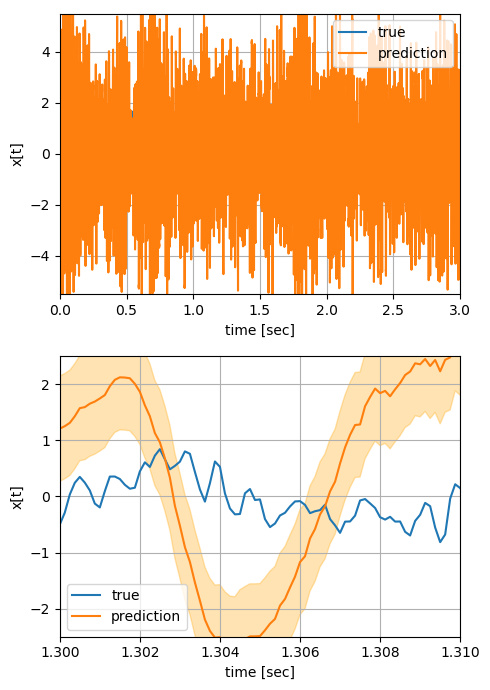

In [15]:
# create figure with subplots
fig, ax = plt.subplots(nrows=2, figsize=(5,7))

μ_x_pred_select = [μ_x[k][1] for k = 1:length(μ_x)]
var_x_pred_select = [Σ_x[k][1,1] for k = 1:length(μ_x)]

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[buffer_size:length(μ_x_pred_select)+buffer_size-1], μ_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[buffer_size:length(μ_x_pred_select)+buffer_size-1], μ_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].fill_between(t[buffer_size:length(μ_x_pred_select)+buffer_size-1], μ_x_pred_select .- sqrt.(var_x_pred_select), μ_x_pred_select .+ sqrt.(var_x_pred_select), alpha=0.3, color="orange")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-5.5, 5.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.3,1.31), ax[2].set_ylim(-2.5, 2.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

plt.tight_layout()

plt.savefig("figures/all_airco_AR01.png", dpi=500)

# create audioplayers
audioplayers(x_time, x_time_clean, μ_x_pred_select, fs=fs_desired)
;

## Performance metrics

In [11]:
MSE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[buffer_size:length(μ_x_pred_select)+buffer_size-1]).^2)

6.74587757977364

In [12]:
MAE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[buffer_size:length(μ_x_pred_select)+buffer_size-1]))

2.1496317930597266

In [13]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, logpdf(Distributions.Normal(μ_x_pred_select[k], sqrt(var_x_pred_select[k])), buf.buffer_s[1]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 23970       mean:-4.356745645456774